<a href="https://colab.research.google.com/github/IllgamhoDuck/googleXproject/blob/master/Quantum_Simulator_with_Tensornetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Simulator with TensorNetwork
**Build a quantum simulator using Tensornetwork with Jax**



## Setting environment
- package install
- package import

In [0]:
!pip install --quiet tensornetwork jax jaxlib qiskit nxpd pylatexenc

In [0]:
%matplotlib inline

# qiskit - test and visualize
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions.simulator import Snapshot
from qiskit.extensions.simulator.snapshot import snapshot

# tensornetwork
import numpy as np
import jax
import tensornetwork as tn

# math
import math

# test
import os
import time
import random
from tqdm import tqdm_notebook as tqdm

In [0]:
tn.set_default_backend("jax")
qasm_simulator = Aer.get_backend('qasm_simulator')
statevector_simulator = Aer.get_backend('statevector_simulator')

class colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    CEND      = '\33[0m'
    CBOLD     = '\33[1m'
    CITALIC   = '\33[3m'
    CURL      = '\33[4m'
    CBLINK    = '\33[5m'
    CBLINK2   = '\33[6m'
    CSELECTED = '\33[7m'

    CBLACK  = '\33[30m'
    CRED    = '\33[31m'
    CGREEN  = '\33[32m'
    CYELLOW = '\33[33m'
    CBLUE   = '\33[34m'
    CVIOLET = '\33[35m'
    CBEIGE  = '\33[36m'
    CWHITE  = '\33[37m'

    CBLACKBG  = '\33[40m'
    CREDBG    = '\33[41m'
    CGREENBG  = '\33[42m'
    CYELLOWBG = '\33[43m'
    CBLUEBG   = '\33[44m'
    CVIOLETBG = '\33[45m'
    CBEIGEBG  = '\33[46m'
    CWHITEBG  = '\33[47m'

    CGREY    = '\33[90m'
    CRED2    = '\33[91m'
    CGREEN2  = '\33[92m'
    CYELLOW2 = '\33[93m'
    CBLUE2   = '\33[94m'
    CVIOLET2 = '\33[95m'
    CBEIGE2  = '\33[96m'
    CWHITE2  = '\33[97m'

    CGREYBG    = '\33[100m'
    CREDBG2    = '\33[101m'
    CGREENBG2  = '\33[102m'
    CYELLOWBG2 = '\33[103m'
    CBLUEBG2   = '\33[104m'
    CVIOLETBG2 = '\33[105m'
    CBEIGEBG2  = '\33[106m'
    CWHITEBG2  = '\33[107m'

c = colors

## Introduction to Quantum simulator

1. What is quantum simulator?
2. How to build a circuit
3. How to check the result
4. Other useful features


### 1. **What is quantum simulator?**



It is a real quantum computer which can simulate the real quantum system.
At this colab it means different. Quantum simulator indicates a program simulates the quantum system in the classical computer without quantum computer. 

To express the quantum world we use qubit and unitary operator which is also called as quantum gate. The diagram that express the qubit and gate is quantum circuit like the picture below.

**Quantum circuit**

<img src="https://www.codeproject.com/KB/recipes/5160469/CircuitExample.png" width=600px>

*Vaughan, Daniel. “Quantum Computation Primer - Part 2.” CodeProject, CodeProject, 26 June 2019, www.codeproject.com/Articles/5160469/Quantum-Computation-Primer-Part-2.*

**Why do we use quantum simulator?**

Quantum simulator is very useful because we can simulate quantum circuit without using the slow and expensive quantum computer. If quantum circuit includes more than 16 qubits it is hard to find a place to simulate.

Also the simulator is not affect by the noise from real world. Quantum computer has a error correction method to protect the result being wrong by the noise but it is not perfect. But simulator will give us the correct result what it should have be given. So the simulator could be used to be a index to check the performance of quantum computer error correction method.

**Quantum simulator limitation**

There is a problem with using classic quantum simulator. When there is 1 qubit the statevector number is 2. When there is 2 qubit it goes up to 4. 3 qubit is 8. 

n qubit = $2^n$ statevector

    [How big will the memory needed?]
    30 qubits -> 1 GB
    40 qubits -> 1 TB
    50 qubits -> 1 PB
    ...

As the qubit size increase it is hard to simulate even for the supercomputer. So This is the limitation of the classic quantum simulator. It means we actually need a quantum computer.

At the below picture you can check the classicially simulatable qubit size.

<img src="https://regmedia.co.uk/2018/03/06/quantum_performance_curve.jpg" width=600px>

Chirgwin, Richard. “'Quantum Supremacy Will Soon Be Ours!', Says Google as It Reveals 72-Qubit Quantum Chip.” • The Register, The Register, 6 Mar. 2018, www.theregister.co.uk/2018/03/06/google_bristlecone_72_qubit_quantum_processsor/.

### 2. **How to build a quantum circuit?**

In this section we will learn how to build a quantum simulator step by step



In [0]:
#@title [step 0] - Quantum simulator code Just run :)
class QuantumSimulator():
    """Quantum simulator with tensornetwork"""
    def __init__(self, qbit_n):
        """
        Args:
            qbit_n: The number of total qubit size
            circuit: Where to store gate
        """
        assert qbit_n > 0, "Qubit size should be at least 1"
        self.qbit_n = qbit_n
        self.circuit = []

    def initialize_circuit(self):
        """
        Initialize the circuit to execute

        Args:
            qbits: Store the first initialized qubits
            measures: Store the edge that used for measure for each qubit
        """
        # Initialize qubit
        self.qbits = [tn.Node(np.array([1 + 0j, 0 + 0j])) for _ in range(self.qbit_n)]

        # Storing the Edge node that will be used to measure for each qubit
        self.measures = [self.qbits[i][0] for i in range(self.qbit_n)]
        self.amplitude = None
        self.result = {}
        self.result_prob = {}
    
    def connect_qubits(self):
        """
        Make the seperate tensornetworks to one tensornetwork using
        2 qubit identity gate
        CI - Control Identity
             [[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]]
        """
        for i in range(self.qbit_n - 1):
            self.add_ci(i, i + 1)

    def x(self, qbit_i):
        """
        Add X gate to specific 1 qubit index 
        x(qbit_i=0)
        """
        self.circuit.append(('x', qbit_i))

    def y(self, qbit_i):
        """
        Add Y gate to specific 1 qubit index 
        y(qbit_i=5)
        """
        self.circuit.append(('y', qbit_i))

    def z(self, qbit_i):
        """
        Add Z gate to specific 1 qubit index 
        z(qbit_i=3)
        """
        self.circuit.append(('z', qbit_i))

    def h(self, qbit_i):
        """
        Add H gate to specific 1 qubit index 
        h(qbit_i=2)
        """
        self.circuit.append(('h', qbit_i))

    def t(self, qbit_i):
        """
        Add T gate to specific 1 qubit index 
        t(qbit_i=0)
        """
        self.circuit.append(('t', qbit_i))

    def cx(self, qbit_c, qbit_t):
        """
        Add CX gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cx(qbit_c=0, qbit_t=1)
        """
        self.circuit.append(('cx', qbit_c, qbit_t))

    def cy(self, qbit_c, qbit_t):
        """
        Add CY gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cy(qbit_c=3, qbit_t=2)
        """
        self.circuit.append(('cy', qbit_c, qbit_t))

    def cz(self, qbit_c, qbit_t):
        """
        Add CZ gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cz(qbit_c=2, qbit_t=4)
        """
        self.circuit.append(('cz', qbit_c, qbit_t))

    def ch(self, qbit_c, qbit_t):
        """
        Add CH gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        ch(qbit_c=1, qbit_t=3)
        """
        self.circuit.append(('ch', qbit_c, qbit_t))

    def add_x(self, qbit_i):
        X = tn.Node(np.array([[0, 1],
                              [1, 0]]))
        self.measures[qbit_i] ^ X[0]
        self.measures[qbit_i] = X[1]

    def add_y(self, qbit_i):
        Y = tn.Node(np.array([[0, 1j],
                              [-1j, 0]]))
        self.measures[qbit_i] ^ Y[0]
        self.measures[qbit_i] = Y[1]

    def add_z(self, qbit_i):
        Z = tn.Node(np.array([[1, 0],
                              [0, -1]]))
        self.measures[qbit_i] ^ Z[0]
        self.measures[qbit_i] = Z[1]

    def add_h(self, qbit_i):
        h_f = 1/math.sqrt(2)
        H = tn.Node(np.array([[h_f, h_f],
                              [h_f, -h_f]]))
        self.measures[qbit_i] ^ H[0]
        self.measures[qbit_i] = H[1]

    def add_t(self, qbit_i):
        e_j_pi = math.e ** ((1j * math.pi) / 4)
        T = tn.Node(np.array([[1, 0],
                              [0, e_j_pi]]))
        self.measures[qbit_i] ^ T[0]
        self.measures[qbit_i] = T[1]

    def add_cx(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cx = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1],
                       [0, 0, 1, 0]])
        CX = tn.Node(cx.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CX[0]
        self.measures[qbit_t] ^ CX[1]
        self.measures[qbit_c] = CX[2]
        self.measures[qbit_t] = CX[3]

    def add_cy(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cy = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1j],
                       [0, 0, -1j, 0]])
        CY = tn.Node(cy.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CY[0]
        self.measures[qbit_t] ^ CY[1]
        self.measures[qbit_c] = CY[2]
        self.measures[qbit_t] = CY[3]


    def add_cz(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cz = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, -1]])
        CZ = tn.Node(cz.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CZ[0]
        self.measures[qbit_t] ^ CZ[1]
        self.measures[qbit_c] = CZ[2]
        self.measures[qbit_t] = CZ[3]

    def add_ch(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
            h_f: hadamard factor
        """
        h_f = 1/math.sqrt(2)
        ch = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, h_f, h_f],
                       [0, 0, h_f, -h_f]])
        CH = tn.Node(ch.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CH[0]
        self.measures[qbit_t] ^ CH[1]
        self.measures[qbit_c] = CH[2]
        self.measures[qbit_t] = CH[3]

    def add_ci(self, qbit_c, qbit_t):
        """
        Control Identity matrix for connect
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        ci = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])
        CI = tn.Node(ci.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CI[0]
        self.measures[qbit_t] ^ CI[1]
        self.measures[qbit_c] = CI[2]
        self.measures[qbit_t] = CI[3]

    def generate_result(self):
        for i in range(2 ** self.qbit_n):
            # Generate statevector
            statevector = ""
            for shift in range(self.qbit_n):
                statevector = str((i >> shift) & 1) + statevector
            
            # Check the amplitude
            amp = self.amplitude[self.bitstring_to_int(statevector)]
            amp = complex(str(amp))

            if amp == 0:
                continue

            # TODO: Figure out how to get value out of jax array
            self.result[statevector] = amp 
            self.result_prob[statevector] = (amp*amp.conjugate()).real

    def bitstring_to_int(self, bitstring):
        int_list = []
        for i in bitstring[::-1]:
            int_list.append(int(i))
        return tuple(int_list)

    def execute_circuit(self):
        """
        gate is structed as following
        1 qubit gate - (gate_name, qubit_index)
        2 qubit gate - (gate_name, qubit_control_index, qubit_target_index)
        """

        # Connect the qubits
        for gate in self.circuit:
            if gate[0] in ['cx', 'cy', 'cz', 'ch']:
                exec('self.add_{}({}, {})'.format(gate[0], gate[1], gate[2]))
            else:
                exec('self.add_{}({})'.format(gate[0], gate[1]))

        nodes = tn.reachable(self.qbits[0])
        self.amplitude = tn.contractors.greedy(nodes, output_edge_order=self.measures).tensor

    def clear_circuit(self):
        self.circuit = []

    def change_qubit_size(self, size):
        assert size > 0, "Qubit size should be at least 1"
        self.qbit_n = size

    def execute(self):
        assert self.qbit_n > 0, "Qubit size should be at least 1"
        self.initialize_circuit()
        self.connect_qubits()
        self.execute_circuit()
        self.generate_result()


#### [step 1] - Create a quantum circuit


You have to choose the size of the qubit the circuit will use

In [0]:
# Choose the size of qubit size
qubit_size = 3
circuit = QuantumSimulator(qubit_size)

#### [step 2] - Add gates to qubit


Its time to apply quantum unitary gate to the qubits! There are total 9 gates we can use. Check out the following gates we can use :) You can add the gate to circuit by following command


    [1qubit gate] - specify gate type and qubit index
    circuit.[gate type]([qubit index])
    circuit.x(0)

    [2qubit gate] - specify gate type and control qubit / target qubit index
    circuit.[gate type]([control qubit index, target qubit index])
    circuit.cx(0, 1)


**1qubit gate**

$X_{gate} = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$
$Y_{gate} = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}$
$Z_{gate} = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$

$H_{gate} = \begin{pmatrix} \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} \end{pmatrix}$
$T_{gate} = \begin{pmatrix} 1 & 0 \\ 0 & e^\frac{i\pi}{4} \end{pmatrix}$

**2qubit gate**

$CX_{gate} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$
$CY_{gate} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & -i \\ 0 & 0 & i & 0 \end{pmatrix}$

$CZ_{gate} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{pmatrix}$
$CH_{gate} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\ 0 & 0 & \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} \end{pmatrix}$

In [0]:
# Add the gate to the circuit
circuit.h(0) # Add gate H to qubit 0
circuit.h(1) # Add gate H to qubit 1
circuit.cx(0, 2) # Add gate CX from qubit 0 to qubit 2
circuit.cx(1, 2) # Add gate CX from qubit 1 to qubit 2

### 3. **How to check the result**

Now you can run the quantum simulator!

    circuit.execute()

And now the result will be stored inside the simulator

    The basic result will be stored in statevector with amplitude
    And also provided with 

    circuit.result - statevector with amplitude
    circuit.result_prob - statevector with probability

In [0]:
# Run the circuit
circuit.execute()

# Checkout the result
print(circuit.result)
print(circuit.result_prob)

{'000': (0.49999997+0j), '011': (0.49999997+0j), '101': (0.49999997+0j), '110': (0.49999997+0j)}
{'000': 0.2499999700000009, '011': 0.2499999700000009, '101': 0.2499999700000009, '110': 0.2499999700000009}


### 4. **Other useful features**

1. Check the gates on circuit
2. Clear the circuit
3. Change the qubit size

##### 1. **Check the gates on circuit**

    circuit.circuit

Checkout the circuit gate that is stored inside. 

    <TIP>
    You can directly put the gates to the circuit than it will be changed

In [0]:
circuit.circuit

[('h', 0), ('h', 1), ('cx', 0, 2), ('cx', 1, 2)]

##### 2. **Clear the circuit**

    circuit.clear_circuit()

This will remove all the gates inside your circuit

In [0]:
circuit.clear_circuit()

In [0]:
circuit.circuit

[]

In [0]:
# Run the circuit
circuit.execute()

# Checkout the result
print(circuit.result)
print(circuit.result_prob)

{'000': (1+0j)}
{'000': 1.0}


##### 3. **Change the qubit size**

    circuit.change_qubit_size(3)

This will remove all the gates inside your circuit

In [0]:
# Run the circuit
circuit.execute()

# Checkout the result
print(circuit.result)
print(circuit.result_prob)

{'000': (1+0j)}
{'000': 1.0}


In [0]:
circuit.change_qubit_size(2)

In [0]:
# Run the circuit
circuit.execute()

# Checkout the result
print(circuit.result)
print(circuit.result_prob)

{'00': (1+0j)}
{'00': 1.0}


## Quantum Simulator Test

1. Q1 - bell state
2. Q2 - swap
3. Q3 - gate cancelation
4. Basic test
    - T, CH test
    - 5 qubit test
5. Advanced test
    - Random circuit test with random qubit size and random gate size
6. Test results

In [0]:
class QuantumSimulator():
    """Quantum simulator with tensornetwork"""
    def __init__(self, qbit_n):
        """
        Args:
            qbit_n: The number of total qubit size
            circuit: Where to store gate
        """
        assert qbit_n > 0, "Qubit size should be at least 1"
        self.qbit_n = qbit_n
        self.circuit = []

    def initialize_circuit(self):
        """
        Initialize the circuit to execute

        Args:
            qbits: Store the first initialized qubits
            measures: Store the edge that used for measure for each qubit
        """
        # Initialize qubit
        self.qbits = [tn.Node(np.array([1 + 0j, 0 + 0j])) for _ in range(self.qbit_n)]

        # Storing the Edge node that will be used to measure for each qubit
        self.measures = [self.qbits[i][0] for i in range(self.qbit_n)]
        self.amplitude = None
        self.result = {}
        self.result_prob = {}
   
    def connect_qubits(self):
        """
        Make the seperate tensornetworks to one tensornetwork using
        2 qubit identity gate
        CI - Control Identity
             [[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]]
        """
        for i in range(self.qbit_n - 1):
            self.add_ci(i, i + 1)

    def x(self, qbit_i):
        """
        Add X gate to specific 1 qubit index 
        x(qbit_i=0)
        """
        self.circuit.append(('x', qbit_i))

    def y(self, qbit_i):
        """
        Add Y gate to specific 1 qubit index 
        y(qbit_i=5)
        """
        self.circuit.append(('y', qbit_i))

    def z(self, qbit_i):
        """
        Add Z gate to specific 1 qubit index 
        z(qbit_i=3)
        """
        self.circuit.append(('z', qbit_i))

    def h(self, qbit_i):
        """
        Add H gate to specific 1 qubit index 
        h(qbit_i=2)
        """
        self.circuit.append(('h', qbit_i))

    def t(self, qbit_i):
        """
        Add T gate to specific 1 qubit index 
        t(qbit_i=0)
        """
        self.circuit.append(('t', qbit_i))

    def cx(self, qbit_c, qbit_t):
        """
        Add CX gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cx(qbit_c=0, qbit_t=1)
        """
        self.circuit.append(('cx', qbit_c, qbit_t))

    def cy(self, qbit_c, qbit_t):
        """
        Add CY gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cy(qbit_c=3, qbit_t=2)
        """
        self.circuit.append(('cy', qbit_c, qbit_t))

    def cz(self, qbit_c, qbit_t):
        """
        Add CZ gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cz(qbit_c=2, qbit_t=4)
        """
        self.circuit.append(('cz', qbit_c, qbit_t))

    def ch(self, qbit_c, qbit_t):
        """
        Add CH gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        ch(qbit_c=1, qbit_t=3)
        """
        self.circuit.append(('ch', qbit_c, qbit_t))

    def add_x(self, qbit_i):
        X = tn.Node(np.array([[0, 1],
                              [1, 0]]))
        self.measures[qbit_i] ^ X[0]
        self.measures[qbit_i] = X[1]

    def add_y(self, qbit_i):
        Y = tn.Node(np.array([[0, 1j],
                              [-1j, 0]]))
        self.measures[qbit_i] ^ Y[0]
        self.measures[qbit_i] = Y[1]

    def add_z(self, qbit_i):
        Z = tn.Node(np.array([[1, 0],
                              [0, -1]]))
        self.measures[qbit_i] ^ Z[0]
        self.measures[qbit_i] = Z[1]

    def add_h(self, qbit_i):
        h_f = 1/math.sqrt(2)
        H = tn.Node(np.array([[h_f, h_f],
                              [h_f, -h_f]]))
        self.measures[qbit_i] ^ H[0]
        self.measures[qbit_i] = H[1]

    def add_t(self, qbit_i):
        e_j_pi = math.e ** ((1j * math.pi) / 4)
        T = tn.Node(np.array([[1, 0],
                              [0, e_j_pi]]))
        self.measures[qbit_i] ^ T[0]
        self.measures[qbit_i] = T[1]

    def add_cx(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cx = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1],
                       [0, 0, 1, 0]])
        CX = tn.Node(cx.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CX[0]
        self.measures[qbit_t] ^ CX[1]
        self.measures[qbit_c] = CX[2]
        self.measures[qbit_t] = CX[3]

    def add_cy(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cy = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1j],
                       [0, 0, -1j, 0]])
        CY = tn.Node(cy.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CY[0]
        self.measures[qbit_t] ^ CY[1]
        self.measures[qbit_c] = CY[2]
        self.measures[qbit_t] = CY[3]


    def add_cz(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cz = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, -1]])
        CZ = tn.Node(cz.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CZ[0]
        self.measures[qbit_t] ^ CZ[1]
        self.measures[qbit_c] = CZ[2]
        self.measures[qbit_t] = CZ[3]

    def add_ch(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
            h_f: hadamard factor
        """
        h_f = 1/math.sqrt(2)
        ch = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, h_f, h_f],
                       [0, 0, h_f, -h_f]])
        CH = tn.Node(ch.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CH[0]
        self.measures[qbit_t] ^ CH[1]
        self.measures[qbit_c] = CH[2]
        self.measures[qbit_t] = CH[3]

    def add_ci(self, qbit_c, qbit_t):
        """
        Control Identity matrix for connect
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        ci = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])
        CI = tn.Node(ci.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CI[0]
        self.measures[qbit_t] ^ CI[1]
        self.measures[qbit_c] = CI[2]
        self.measures[qbit_t] = CI[3]

    def generate_result(self):
        for i in range(2 ** self.qbit_n):
            # Generate statevector
            statevector = ""
            for shift in range(self.qbit_n):
                statevector = str((i >> shift) & 1) + statevector
            
            # Check the amplitude
            amp = self.amplitude[self.bitstring_to_int(statevector)]
            amp = complex(str(amp))

            if amp == 0:
                continue

            # TODO: Figure out how to get value out of jax array
            self.result[statevector] = amp 
            self.result_prob[statevector] = (amp*amp.conjugate()).real

    def bitstring_to_int(self, bitstring):
        int_list = []
        for i in bitstring[::-1]:
            int_list.append(int(i))
        return tuple(int_list)

    def execute_circuit(self):
        """
        gate is structed as following
        1 qubit gate - (gate_name, qubit_index)
        2 qubit gate - (gate_name, qubit_control_index, qubit_target_index)
        """

        # Connect the qubits
        for gate in self.circuit:
            if gate[0] in ['cx', 'cy', 'cz', 'ch']:
                exec('self.add_{}({}, {})'.format(gate[0], gate[1], gate[2]))
            else:
                exec('self.add_{}({})'.format(gate[0], gate[1]))

        nodes = tn.reachable(self.qbits[0])
        self.amplitude = tn.contractors.greedy(nodes, output_edge_order=self.measures).tensor

    def clear_circuit(self):
        self.circuit = []

    def change_qubit_size(self, size):
        assert size > 0, "Qubit size should be at least 1"
        self.qbit_n = size

    def execute(self):
        assert self.qbit_n > 0, "Qubit size should be at least 1"
        self.initialize_circuit()
        self.connect_qubits()
        self.execute_circuit()
        self.generate_result()


### Q1 - bell state

In [0]:
circuit = QuantumSimulator(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'00': (0.70710677+0j), '11': (0.70710677+0j)}
{'00': 0.4999999841798329, '11': 0.4999999841798329}


In [0]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure(q, c)

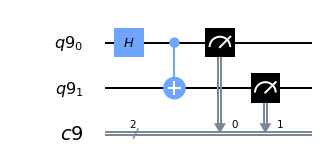

In [0]:
circuit.draw(output='mpl')

In [0]:
execute(circuit, qasm_simulator).result().get_counts()

{'00': 479, '11': 545}

### Q2 - swap

In [0]:
circuit = QuantumSimulator(2)
circuit.x(1)
circuit.cx(0, 1)
circuit.cx(1, 0)
circuit.cx(0, 1)
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'01': (1+0j)}
{'01': 1.0}


In [0]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.x(1)
circuit.cx(0, 1)
circuit.cx(1, 0)
circuit.cx(0, 1)
circuit.measure(q, c)

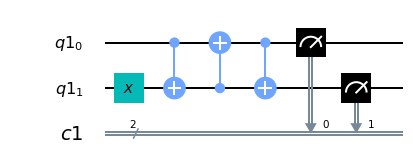

In [0]:
circuit.draw(output='mpl')

In [0]:
execute(circuit, qasm_simulator).result().get_counts()

{'01': 1024}

### Q3 - gate cancelation

In [0]:
circuit = QuantumSimulator(3)

# connect
circuit.y(0)
circuit.h(1)
circuit.x(2)
circuit.cx(0, 1)
circuit.h(0)
circuit.cz(1, 2)
circuit.cy(0, 2)

# deconnect
circuit.cy(0, 2)
circuit.cz(1, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.x(2)
circuit.h(1)
circuit.y(0)
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'000': (0.99999994+0j), '001': (8.881784e-16+0j), '010': (8.881784e-16+0j), '011': (-8.881784e-16+0j)}
{'000': 0.9999998800000036, '001': 7.888608702265599e-31, '010': 7.888608702265599e-31, '011': 7.888608702265599e-31}


In [0]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
circuit = QuantumCircuit(q, c)

# connect
circuit.y(0)
circuit.h(1)
circuit.x(2)
circuit.cx(0, 1)
circuit.h(0)
circuit.cz(1, 2)
circuit.cy(0, 2)

# deconnect
circuit.cy(0, 2)
circuit.cz(1, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.x(2)
circuit.h(1)
circuit.y(0)

circuit.measure(q, c)

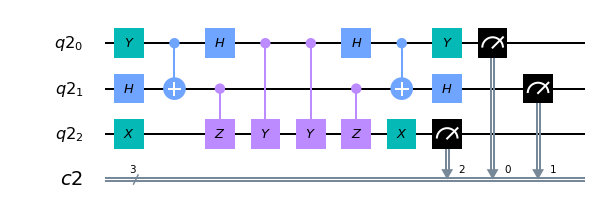

In [0]:
circuit.draw(output='mpl')

In [0]:
execute(circuit, qasm_simulator).result().get_counts()

{'000': 1024}

### Basic test

#### T, CH gate test

In [0]:
circuit = QuantumSimulator(2)
circuit.t(0)
circuit.ch(0, 1)
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'00': (1+0j)}
{'00': 1.0}


In [0]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.t(0)
circuit.ch(0, 1)
circuit.measure(q, c)

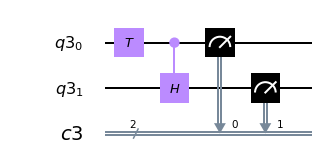

In [0]:
circuit.draw(output='mpl')

In [0]:
execute(circuit, qasm_simulator).result().get_counts()

{'00': 1024}

In [0]:
circuit = QuantumSimulator(2)
circuit.x(0)
circuit.ch(0, 1)
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'01': (0.70710677+0j), '11': (0.70710677+0j)}
{'01': 0.4999999841798329, '11': 0.4999999841798329}


In [0]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.x(0)
circuit.ch(0, 1)
circuit.measure(q, c)

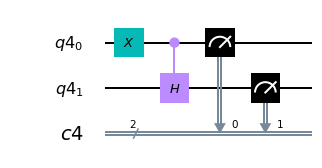

In [0]:
circuit.draw(output='mpl')

In [0]:
execute(circuit, qasm_simulator).result().get_counts()

{'01': 519, '11': 505}

In [0]:
circuit = QuantumSimulator(2)
circuit.t(0)
circuit.y(0)
circuit.t(0)
circuit.ch(0, 1)
circuit.ch(1, 0)
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'01': (-0.49999997+0.49999997j), '10': (-0.35355335+0.35355335j), '11': (0.35355335-0.35355335j)}
{'01': 0.4999999400000018, '10': 0.24999994259244498, '11': 0.24999994259244498}


In [0]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.t(0)
circuit.y(0)
circuit.t(0)
circuit.ch(0, 1)
circuit.ch(1, 0)
circuit.measure(q, c)

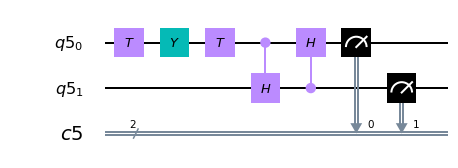

In [0]:
circuit.draw(output='mpl')

In [0]:
execute(circuit, qasm_simulator).result().get_counts()

{'01': 529, '10': 234, '11': 261}

In [0]:
circuit = QuantumSimulator(2)
circuit.t(0)
circuit.y(0)
circuit.ch(0, 1)
circuit.ch(1, 0)
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'01': 0.70710677j, '10': 0.49999997j, '11': -0.49999997j}
{'01': 0.4999999841798329, '10': 0.2499999700000009, '11': 0.2499999700000009}


In [0]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.t(0)
circuit.y(0)
circuit.ch(0, 1)
circuit.ch(1, 0)
circuit.measure(q, c)

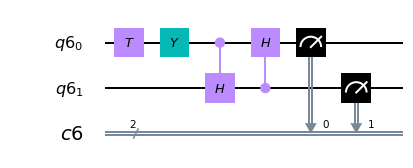

In [0]:
circuit.draw(output='mpl')

In [0]:
execute(circuit, qasm_simulator).result().get_counts()

{'01': 554, '10': 232, '11': 238}

#### 5 qubit test

In [0]:
circuit = QuantumSimulator(5)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)
circuit.cx(0, 1)
circuit.t(0)
circuit.y(0)
circuit.ch(4, 0)
circuit.ch(1, 3)
circuit.cy(2, 3)
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'00000': (0.17677668-0.17677668j), '00001': 0.24999997j, '00010': (0.24999997-0.24999997j), '00011': 0.35355335j, '00100': (-0.17677668-0.17677668j), '00101': (0.24999997+0j), '00110': (3.1720124e-09+3.1720124e-09j), '00111': (-4.485903e-09+0j), '01000': (0.17677668-0.17677668j), '01001': 0.24999997j, '01010': (-3.1720124e-09+3.1720124e-09j), '01011': -4.485903e-09j, '01100': (0.17677668+0.17677668j), '01101': (-0.24999997+0j), '01110': (0.24999997+0.24999997j), '01111': (-0.35355335+0j)}
{'00000': 0.06249998918364479, '00001': 0.062499985000000896, '00010': 0.12499997000000179, '00011': 0.12499997129622249, '00100': 0.06249998918364479, '00101': 0.062499985000000896, '00110': 2.012332533150752e-17, '00111': 2.0123325725409e-17, '01000': 0.06249998918364479, '01001': 0.062499985000000896, '01010': 2.012332533150752e-17, '01011': 2.0123325725409e-17, '01100': 0.06249998918364479, '01101': 0.062499985000000896, '01110': 0.12499997000000179, '01111': 0.12499997129622249}


In [0]:
q = QuantumRegister(5)
c = ClassicalRegister(5)
circuit = QuantumCircuit(q, c)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)
circuit.cx(0, 1)
circuit.t(0)
circuit.y(0)
circuit.ch(4, 0)
circuit.ch(1, 3)
circuit.cy(2, 3)
circuit.measure(q, c)

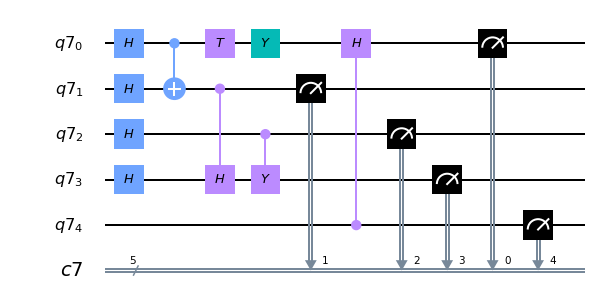

In [0]:
circuit.draw(output='mpl')

In [0]:
execute(circuit, qasm_simulator).result().get_counts()

{'00000': 53,
 '00001': 69,
 '00010': 128,
 '00011': 118,
 '00100': 80,
 '00101': 59,
 '01000': 81,
 '01001': 62,
 '01100': 48,
 '01101': 66,
 '01110': 126,
 '01111': 134}

### Advanced Test

#### Random circuit test with random qubit size and random gate size


In [0]:
class QuantumSimulatorTest():
    """Test the quantum simulator"""
    def __init__(self,
                 min_qubit_size=1,
                 max_qubit_size=5,
                 min_gate_size=1,
                 max_gate_size=40):
        """
        Choose the testing enviroment
        Args:
            min_qubit_size: minimum number of the qubit size
            min_qubit_size: maximum number of the qubit size
            min_qubit_size: minimum number of the gate size
            min_qubit_size: maximum number of the gate size
        """
        self.max_qubit_size = max_qubit_size
        self.min_qubit_size = min_qubit_size
        self.max_gate_size = max_gate_size
        self.min_gate_size = min_gate_size

    def __call__(self,
                 quantum_simulator,
                 ibmq_backend,
                 test_size=10,
                 error_path=None,
                 error_file=None):
        """
        Process test
        Quantum simulator testing using ibmq qiskit
        Args:
            quantum_simulator: quantum simulator that will be used to simulate
            ibmq_backend: ibmq simulator that will be used as referenc
                - qasm_simulator: show the number of shots for each statevector
                - statevector_simualtor: show the amplitude and prob for each statevector
                                         measure gates are disabled
            test_size: total test case size
            error_path: where to store the error case
            error_file: name of the error file
        """
        # Check IBMQ backend
        self.ibmq_backend = ibmq_backend.configuration().backend_name

        # Check the correct
        total = 0
        correct = 0
        test_start_time = time.time()

        # Store the error case
        if error_path:
            if not(os.path.isdir(error_path)):
                os.makedirs(error_path)
            f = open(os.path.join(error_path, error_file), 'w')

        # Run the test!
        for test_i in tqdm(range(test_size)):
            # Generate the random circuit and qasm(IBM Qiskit)
            random_qubit_size = random.randint(self.min_qubit_size, self.max_qubit_size)
            random_gate_size = random.randint(self.min_gate_size, self.max_gate_size)
            circuit, qasm = self.random_circuit(random_qubit_size, random_gate_size)

            # Print out the current test case information
            print(c.BOLD)
            print('TEST CASE [{} / {}] qubit: {} gate: {}'.format(test_i + 1,
                                                                  test_size,
                                                                  random_qubit_size,
                                                                  random_gate_size))
            print(c.ENDC)

            # Run the Quantum simulator and get the result
            qs_start_time = time.time()
            quantum_simulator.change_qubit_size(random_qubit_size)
            quantum_simulator.circuit = circuit
            quantum_simulator.execute()
            qs_end_time = time.time()

            self.qs_result = quantum_simulator.result_prob

            # Run IBM qiskit simulator and get the result
            shots = 1000 # default

            ibmq_start_time = time.time()
            ibmq_circuit = QuantumCircuit.from_qasm_str(qasm)
            self.ibmq_result = execute(ibmq_circuit, ibmq_backend, shots=shots).result()
            ibmq_end_time = time.time()

            ############################################################
            ### PRINT OUT THE INFORMATIONS #############################
            ############################################################
            
            # 1. Circuit information
            print(circuit)
            print(ibmq_circuit)

            # 2. Quantum simulation
            print(c.BOLD + '[ QUANTUM SIMULATOR ]' + c.ENDC)
            print(c.CURL, end="")
            print("Quantum simulator tested time: %s sec\n" % format(qs_end_time - qs_start_time))
            print(c.ENDC, end="")
            print(quantum_simulator.result)
            print(self.qs_result)
            print('')

            # 3. IBMQ simulation
            print(c.BOLD + '[ IBM QISKIT ]' + c.ENDC)
            print(c.CURL, end="")
            print("IBMQ tested time: %s sec\n" % format(ibmq_end_time - ibmq_start_time))
            print(c.ENDC, end="")
            if self.ibmq_backend == 'qasm_simulator':
                print(self.ibmq_result.get_counts())
            if self.ibmq_backend == 'statevector_simulator':
                self.generate_ibmq_result(random_qubit_size)
                print(self.ibmq_amp)
                print(self.ibmq_prob)
            print('')

            # 4. Compare the result
            print(c.BOLD + '[ COMPARE ]' + c.ENDC)
            cmp_start_time = time.time()
            error_n, cmp_total, total_error = self.compare_probability(shots)
            print(c.CURL, end="")
            print("Comparing time: %s sec" % format(time.time() - cmp_start_time))
            print(c.ENDC)
            if error_n == 0:
                print(c.OKBLUE + 'ERROR OCCUR / TOTAL CHECK: ' + c.ENDC, error_n, '/', cmp_total)
                print(c.OKBLUE + 'TOTAL ERROR: ' + c.ENDC, total_error,'\n')
            else:
                print(c.FAIL + 'ERROR OCCUR / TOTAL CHECK: ' + c.ENDC, error_n, '/', cmp_total)
                print(c.FAIL + 'TOTAL ERROR: ' + c.ENDC, total_error,'\n')

            ############################################################
            ############################################################
            ############################################################

            # Update the error information and save the error case to file
            if error_n == 0:
                correct += 1
            elif error_path and self.ibmq_backend == 'qasm_simulator':
                error_case = ""
                error_case += str(circuit) + '\n'
                error_case += '< Quantum simulator probability >\n'
                error_case += str(self.qs_result) +'\n'
                error_case += '< IBMQ statevector count information >\n'
                error_case += str(self.ibmq_result.get_counts()) + '\n'
                error_case += 'Error occur / Total check: '
                error_case += str(error_n) + '/' + str(cmp_total) + '\n'
                error_case += 'Total error: '
                error_case += str(total_error) + '\n\n'
                f.write(error_case)
            elif error_path and self.ibmq_backend == 'statevector_simulator':
                error_case = ""
                error_case += str(circuit) + '\n'
                error_case += '< Quantum simulator amplitude & probability >\n'
                error_case += str(quantum_simulator.result) +'\n'
                error_case += str(self.qs_result) +'\n'
                error_case += '< IBMQ amplitude & probability >\n'
                error_case += str(self.ibmq_amp) + '\n'
                error_case += str(self.ibmq_prob) + '\n'
                error_case += 'Error occur / Total check: '
                error_case += str(error_n) + '/' + str(cmp_total) + '\n'
                error_case += 'Total error: '
                error_case += str(total_error) + '\n\n'
                f.write(error_case)
            total += 1

        # Close the error case file
        if error_path:
            f.close()
        
        # Print out the final result
        if correct == total:
            print(c.OKBLUE + "The final result is {} / {}".format(correct, total) + c.ENDC)
        else:
            print(c.FAIL + "The final result is {} / {}".format(correct, total) + c.ENDC)
        print("Total tested time: %s sec" % format(time.time() - test_start_time))

    def generate_ibmq_result(self, qubit_size):
        """
        Generate statevector dictionary stores probability of ibmq simulator
        based on amplitude from ibmq statevector simulator
        """
        ibmq_amplitude = self.ibmq_result.data()['statevector']
        self.ibmq_amp = {}
        self.ibmq_prob = {}
        for i in range(2 ** qubit_size):
            # Generate statevector
            statevector = ""
            for shift in range(qubit_size):
                statevector = str((i >> shift) & 1) + statevector
            
            # Check the amplitude
            amp_list = ibmq_amplitude[i]
            amp = complex(amp_list[0], amp_list[1])

            if amp == 0:
                continue

            self.ibmq_amp[statevector] = amp 
            self.ibmq_prob[statevector] = (amp*amp.conjugate()).real
    
    def compare_probability(self, shots, delta=1e-6):
        """
        Check each statevector probability and if the value is
        more than give delta(default: 1e-6) value consider as error
        """
        total_error = 0
        error_n = 0
        cmp_total = 0

        # Get statevector info from both simulator
        if self.ibmq_backend == 'qasm_simulator':
            ibmq_count = self.ibmq_result.get_counts()
            state_vectors = list(set(self.qs_result.keys()).union(set(ibmq_count.keys())))
        if self.ibmq_backend == 'statevector_simulator':
            state_vectors = list(set(self.qs_result.keys()).union(set(self.ibmq_amp.keys())))
        
        # Check is there is an error
        for state_vector in state_vectors:
            qs_val = self.qs_result.get(state_vector, 0)

            if self.ibmq_backend == 'qasm_simulator':
                ibmq_val = ibmq_count.get(state_vector, 0)/shots
            if self.ibmq_backend == 'statevector_simulator':
                ibmq_val = self.ibmq_prob.get(state_vector, 0)

            error = abs(qs_val - ibmq_val)
            total_error += error
            if error > delta:
                error_n += 1
            cmp_total += 1

        return error_n, cmp_total, total_error

    def random_circuit(self, qubit_size=5, gate_size=20):
        """
        Args:
            gate_1: list of 1 qubit gates
            gate_2: list of 2 qubit gates
            qubit_list: list of qubit index
        """
        # Quantum Simulator
        gate_1 = ['x', 'y', 'z', 'h', 't']
        gate_2 = ['cx', 'cy', 'cz', 'ch']
        qubit_list = list(range(qubit_size))

        circuit = []
        for _ in range(gate_size):
            if qubit_size == 1 or random.random() > 0.5:
                circuit.append(tuple([random.choice(gate_1), *random.sample(qubit_list, 1)]))
            else:
                circuit.append(tuple([random.choice(gate_2), *random.sample(qubit_list, 2)]))

        # IBM Qiskit
        qasm = self.circuit_to_qasm(circuit, qubit_size)
        
        return circuit, qasm

    def circuit_to_qasm(self, circuit, qubit_size):
        # Add meta data
        qasm_text = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'
        
        # Add quantum bits and classical bits
        qasm_text += 'qreg q[{0}];\ncreg c[{0}];\n'.format(qubit_size)
        
        # Add quantum gates
        for gate in circuit:
            # 1 qubit gate
            if len(gate) == 2:
                qasm_text += '{0} q[{1}];\n'.format(gate[0], gate[1])
            # 2 qubit gate
            elif len(gate) == 3:
                qasm_text += '{0} q[{1}],q[{2}];\n'.format(gate[0], gate[1], gate[2])
            else:
                raise NotImplementedError("Quantum simulator doesn't support qubit gates more than 2")
        
        # Add measure gate
        if self.ibmq_backend == 'qasm_simulator':
            for qbit_i in range(qubit_size):
                qasm_text += 'measure q[{0}] -> c[{0}];\n'.format(qbit_i)
        
        return qasm_text


#### **Quantum Simulator Test**

1. Choose the random simulator qubit & gate range


    min_qubit_size - Size of minumun qubit size to test
    max_qubit_size - Size of maximum qubit size to test
    min_gate_size - Size of minumun gate size to test
    max_gate_size - Size of maximum gate size to test

2. Test the simulator


    quantum_simulator - Built quantum simulator to be tested
    ibmq_backend - The simualtor will be used as backend
        - qasm_simulator: statevector count infomation (default 1000)
        - statevector_simulator: statevector amplitude & probability information
    test_size - Choose how many cases you want to test
    error_path - Choose the path where error case file will be saved
    error_file - Choose the error case file name 

In [0]:
t = QuantumSimulatorTest(min_qubit_size=1,
                         max_qubit_size=5,
                         min_gate_size=1,
                         max_gate_size=100)
circuit = QuantumSimulator(1)

In [0]:
t(quantum_simulator=circuit,
  ibmq_backend=statevector_simulator,
  test_size=1000,
  error_path='/error',
  error_file='error_case.txt')


TEST CASE [1 / 1000] qubit: 1 gate: 57

[('h', 0), ('y', 0), ('t', 0), ('z', 0), ('y', 0), ('t', 0), ('t', 0), ('z', 0), ('x', 0), ('h', 0), ('y', 0), ('z', 0), ('h', 0), ('t', 0), ('y', 0), ('h', 0), ('t', 0), ('z', 0), ('h', 0), ('h', 0), ('x', 0), ('x', 0), ('x', 0), ('z', 0), ('t', 0), ('z', 0), ('z', 0), ('h', 0), ('x', 0), ('y', 0), ('t', 0), ('t', 0), ('z', 0), ('x', 0), ('z', 0), ('h', 0), ('z', 0), ('t', 0), ('y', 0), ('h', 0), ('x', 0), ('y', 0), ('h', 0), ('z', 0), ('t', 0), ('x', 0), ('x', 0), ('h', 0), ('x', 0), ('z', 0), ('h', 0), ('x', 0), ('x', 0), ('t', 0), ('y', 0), ('h', 0), ('x', 0)]
        ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
q_0: |0>┤ H ├┤ Y ├┤ T ├┤ Z ├┤ Y ├┤ T ├┤ T ├┤ Z ├┤ X ├┤ H ├┤ Y ├┤ Z ├┤ H ├┤ T ├»
        └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
 c_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                    

### Test Results

#### Test case

#### Test case that proves minus (-) of Y is opposite

$Y_{gate} = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}$
$Y_{fixed} = \begin{pmatrix} 0 & i \\ -i & 0 \end{pmatrix}$

$CY_{gate} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & -i \\ 0 & 0 & i & 0 \end{pmatrix}$
$CY_{fixed} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & i \\ 0 & 0 & -i & 0 \end{pmatrix}$

In [0]:
case = [('y', 1), ('ch', 1, 0), ('cy', 0, 1), ('t', 0), ('cx', 1, 0), ('h', 1)]

In [0]:
qasm = t.circuit_to_qasm(case, 2)
qasm

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\ncreg c[2];\ny q[1];\nch q[1],q[0];\ncy q[0],q[1];\nt q[0];\ncx q[1],q[0];\nh q[1];\nmeasure q[0] -> c[0];\nmeasure q[1] -> c[1];\n'

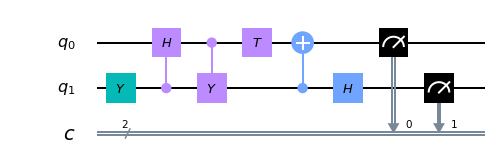

In [0]:
ibmq_circuit = QuantumCircuit.from_qasm_str(qasm)
ibmq_circuit.draw(output='mpl')

In [0]:
circuit = QuantumSimulator(2)
circuit.circuit = case
circuit.execute()
print(circuit.result)
print(circuit.result_prob)

{'01': (0.35355335+0.8535533j), '11': (0.35355335-0.14644662j)}
{'01': 0.8535532072371125, '11': 0.1464465838056469}


In [0]:
execute(ibmq_circuit, qasm_simulator).result().get_counts()

{'01': 868, '11': 156}